*Description: A customized version of measurement-py that uses themes, sub-plots, facets, and groupings, where relevant, to compare distributions and relationships.*

In Chapter 2, we begin visualizing data. Python has a variety of excellent plotting libraries. This chapter uses [seaborn](https://seaborn.pydata.org/index.html), which is built on top of [matplotlib](https://matplotlib.org/stable/index.html#). We occassionally leverage matplotlib to customize plots. In seaborn, we use three families of plotting functions, known as "figure-level" plots in seaborn terminology. Whenever we use one of these function families, we must specify a "kind" of plot, unless the kind we want to use is the default. The table below summarizes the families of plotting functions and the kinds of plots used in this chapter. Seaborn also has more specific, "axes-level," plotting functions, such as `histplot` and `scatterplot`. Axes-level plots are particularly useful for creating sub-plots. 

<div style="text-align:center">

<center>

| Family | Kind |
|----------|----------|
| relplot   | scatter (default), line   |
| displot | hist (default), kde |
| catplot  | bar, box  |

</center>

</div>

## Section 3.1: Measuring Civilian Victimization during Wartime {-}

In [1]:
# import libraries used in chapter with conventinal aliases
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# import data
afghan = pd.read_csv('afghan.csv')

# summarize variables of interest
afghan['age'].describe().round(2)

count    2754.00
mean       32.39
std        12.29
min        15.00
25%        22.00
50%        30.00
75%        40.00
max        80.00
Name: age, dtype: float64

In [2]:
afghan['educ.years'].describe().round(2)

count    2754.00
mean        4.00
std         4.75
min         0.00
25%         0.00
50%         1.00
75%         8.00
max        18.00
Name: educ.years, dtype: float64

In [3]:
afghan['employed'].describe().round(2)

count    2754.00
mean        0.58
std         0.49
min         0.00
25%         0.00
50%         1.00
75%         1.00
max         1.00
Name: employed, dtype: float64

In [4]:
afghan['income'].describe()

count             2600
unique               5
top       2,001-10,000
freq              1420
Name: income, dtype: object

In [5]:
afghan['income'].value_counts(sort=False, dropna=False)

income
2,001-10,000       1420
NaN                 154
10,001-20,000       616
less than 2,000     457
20,001-30,000        93
over 30,000          14
Name: count, dtype: int64

In [6]:
# convert income to a categorical variable and specify levels
afghan['income'] = afghan['income'].astype('category').cat.reorder_categories(
    ['less than 2,000', '2,001-10,000', '10,001-20,000', '20,001-30,000', 
     'over 30,000']
)

afghan['income'].value_counts(sort=False, dropna=False)

income
less than 2,000     457
2,001-10,000       1420
10,001-20,000       616
20,001-30,000        93
over 30,000          14
NaN                 154
Name: count, dtype: int64

In [7]:
pd.crosstab(afghan['violent.exp.ISAF'], afghan['violent.exp.taliban'],
            rownames=['ISAF'], colnames=['Taliban'], normalize=True)

Taliban,0.0,1.0
ISAF,,
0.0,0.495345,0.131844
1.0,0.176909,0.195903


## Section 3.2: Handling Missing Data in Pandas {-}

In [8]:
# print income data for first 10 respondents
afghan['income'].head(10)

0     2,001-10,000
1     2,001-10,000
2     2,001-10,000
3     2,001-10,000
4     2,001-10,000
5              NaN
6    10,001-20,000
7     2,001-10,000
8     2,001-10,000
9              NaN
Name: income, dtype: category
Categories (5, object): ['less than 2,000', '2,001-10,000', '10,001-20,000', '20,001-30,000', 'over 30,000']

In [9]:
# indicate whether respondents' income is missing
afghan['income'].isnull().head(10)

0    False
1    False
2    False
3    False
4    False
5     True
6    False
7    False
8    False
9     True
Name: income, dtype: bool

In [10]:
# count of missing values
afghan['income'].isnull().sum()

154

In [11]:
# proportion of missing values
afghan['income'].isnull().mean()

0.05591866376180102

In [12]:
x = pd.Series([1, 2, 3, np.nan])

# pandas ignores missing values by default
x.mean()

2.0

In [13]:
# we can override the default behavior
x.mean(skipna=False)

nan

The pandas `crosstab` method does not have an argument for including missing values in a contingency table. Instead, we can use the `fillna` method to supply a name for the missing values. 

In [14]:
pd.crosstab(afghan['violent.exp.ISAF'].fillna('Nonresponse'),
            afghan['violent.exp.taliban'].fillna('Nonresponse'), 
            rownames=['ISAF'], colnames=['Taliban'], normalize=True)

Taliban,0.0,1.0,Nonresponse
ISAF,,,
0.0,0.482934,0.128540,0.007988
1.0,0.172476,0.190995,0.007988
Nonresponse,0.002542,0.002905,0.003631


In [15]:
# listwise deletion
afghan_sub = afghan.dropna()

afghan_sub.shape[0]

2554

In [16]:
afghan['income'].dropna().shape[0]

2600

## Section 3.3: Visualizing the Univariate Distribution {-}

### Section 3.3.1: Bar Plot {-}

In [17]:
# a vector of proportions to plot
ISAF_ptable = (afghan['violent.exp.ISAF'].
               value_counts(normalize=True, dropna=False).reset_index())

ISAF_ptable

,violent.exp.ISAF,proportion
0,0.0,0.619463
1,1.0,0.371460
2,NaN,0.009078


In [18]:
# repeat the same for the Taliban
Taliban_ptable = (afghan['violent.exp.taliban'].
                   value_counts(normalize=True, dropna=False).reset_index())

Taliban_ptable

,violent.exp.taliban,proportion
0,0.0,0.657952
1,1.0,0.322440
2,NaN,0.019608


We can view the distributions side-by-side in a barplot using groupings. Grouped visualizations work best in seaborn when the grouping variable is in its own column. 

In [19]:
# add a response column for plotting convenience
ISAF_ptable['response'] = ['No harm', 'Harm', 'Nonresponse']
Taliban_ptable['response'] = ['No harm', 'Harm', 'Nonresponse']

# add an identifer for combatant (the grouping variable)
ISAF_ptable['Combatant'] = 'ISAF'
Taliban_ptable['Combatant'] = 'Taliban'

# stack the two data frames using concatenation; leave out the first column
combatants_ptable = pd.concat([ISAF_ptable.iloc[:,1:], 
                               Taliban_ptable.iloc[:,1:]], axis=0)   

combatants_ptable

,proportion,response,Combatant
0,0.619463,No harm,ISAF
1,0.371460,Harm,ISAF
2,0.009078,Nonresponse,ISAF
0,0.657952,No harm,Taliban
1,0.322440,Harm,Taliban
2,0.019608,Nonresponse,Taliban


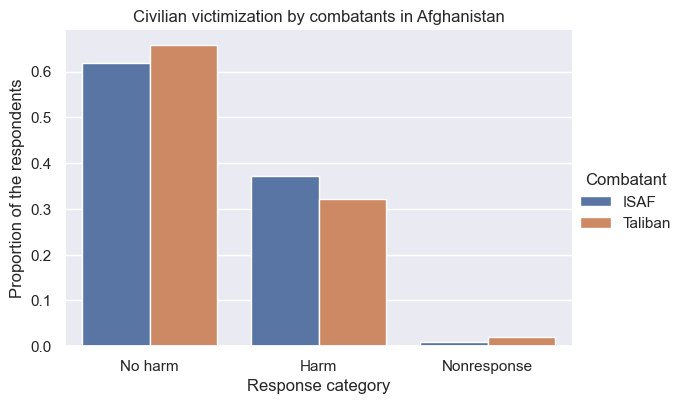

In [20]:
sns.set_theme(style="darkgrid")

sns.catplot(
    data=combatants_ptable, x='response', y='proportion', kind='bar',
    estimator=sum, hue='Combatant', height=4, aspect=1.5
).set(xlabel='Response category', ylabel='Proportion of the respondents',
      title='Civilian victimization by combatants in Afghanistan')

Notice, we use `estimator=sum` because seaborn bar plots aggregate the data by a given function. The default aggregation function is `mean`. Since we have already calculated proportions, we can use `sum` to ensure there is no further aggregation. Another strategy for creating the bar plot is to use the mean aggregation directly on the original data frame categories. 

Additionally, we set the height and aspect ratios directly. The default height is 5 inches for seaborn figure-level plots, and the default aspect ratio is 1. The aspect ratio is the ratio of the width to the height. Therefore, the default width is 5 inches.

### Section 3.3.2: Histogram {-}

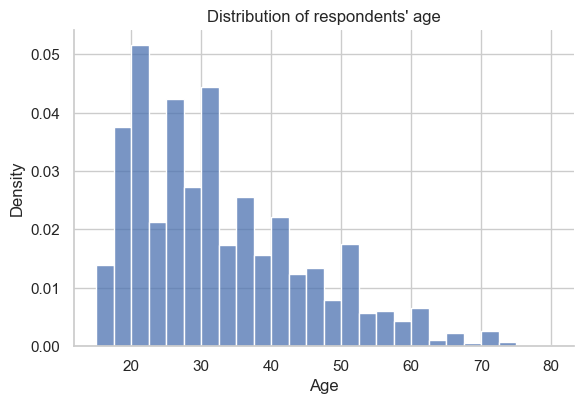

In [21]:
# Use a different seaborn theme
sns.set_theme(style="whitegrid")

sns.displot(
    data=afghan, x='age', stat='density', height=4, aspect=1.5
).set(title="Distribution of respondents' age", xlabel='Age')

By default, seaborn removes the top and right plot spines. We can use the `despine` method to add them back. 

Text(1.5, 0.5, 'median')

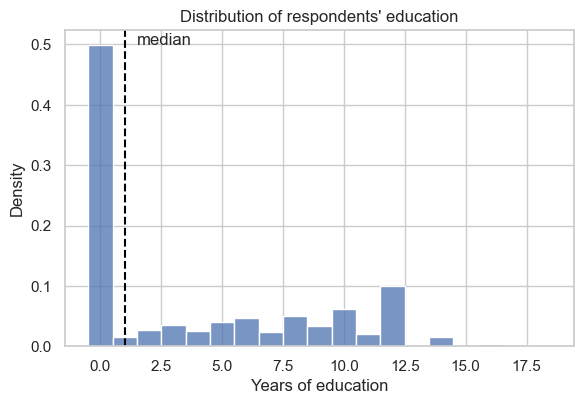

In [22]:
# histogram of education
# use binrange and binwidth to control the bins
sns.displot(
    data=afghan, x='educ.years', stat='density', 
    binrange=(-0.5, 18.5), binwidth=1, height=4, aspect=1.5
).set(title="Distribution of respondents' education", 
      xlabel='Years of education').despine(right=False, top=False)

# add a vertical line representing the median
plt.axvline(x=afghan['educ.years'].median(), color='black', linestyle='--')

# add a text label for the median
plt.text(x=1.5, y=0.5, s='median')

### Section 3.3.3: Box Plot {-}

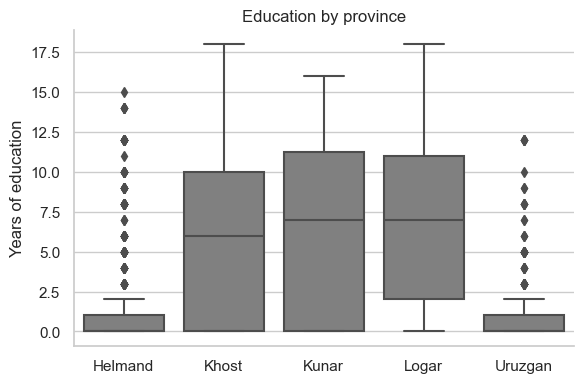

In [23]:
# convert province to a categorical variable
# not necessary for plotting, but useful for other analyses
afghan['province'] = afghan['province'].astype('category')

sns.catplot(
    data=afghan, x='province', y='educ.years', kind='box', color='gray',
    height=4, aspect=1.5
).set(title='Education by province', xlabel='', ylabel='Years of education')

In [24]:
afghan.groupby('province')['violent.exp.taliban'].mean()

province
Helmand    0.504222
Khost      0.233227
Kunar      0.303030
Logar      0.080247
Uruzgan    0.454545
Name: violent.exp.taliban, dtype: float64

In [25]:
afghan.groupby('province')['violent.exp.ISAF'].mean()

province
Helmand    0.541023
Khost      0.242424
Kunar      0.398990
Logar      0.144033
Uruzgan    0.496042
Name: violent.exp.ISAF, dtype: float64

### Section 3.3.4: Saving Plots {-}

In [26]:
# Option 1: Save via point-and-click in IDE

# Option 2: Run plot code plus plt.savefig()

sns.catplot(
    data=afghan, x='province', y='educ.years', kind='box', color='gray',
    height=4, aspect=1.5
).set(title='Education by province', xlabel='', ylabel='Years of education')

plt.savefig('education-by-province.png', bbox_inches='tight')

plt.close() # preventing plot from re-displaying

## Section 3.4: Survey Sampling {-}

### Section 3.4.1: The Role of Randomization {-}

In [27]:
# load village data 
afghan_village = pd.read_csv('afghan-village.csv')

# add a more descriptive variable for survey status to aid plotting 
afghan_village['village_surveyed_desc'] = (
    np.where(afghan_village['village.surveyed']==1, 'Sampled', 'Nonsampled')
    )

# add the natural log of population to the data frame
afghan_village['log_pop'] = np.log(afghan_village['population'])

[Text(0, 0.5, 'Log population'), Text(0.5, 0, '')]

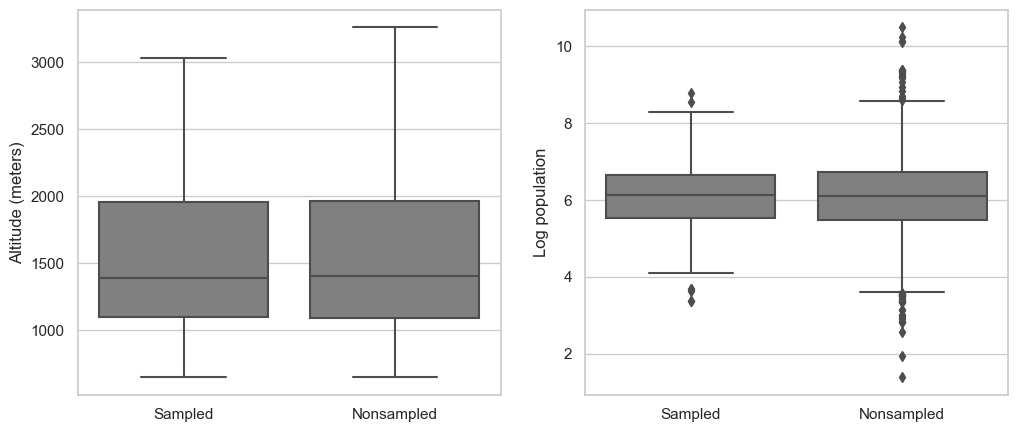

In [28]:
# creating subplots requires using axes-level functions
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# boxplots for altitude 
sns.boxplot(
    data=afghan_village, x='village_surveyed_desc', y='altitude', 
    color='gray', ax=axs[0]
).set(ylabel='Altitude (meters)', xlabel='')

# boxplots for log population 
sns.boxplot(
    data=afghan_village, x='village_surveyed_desc', y='log_pop', 
    color='gray', ax=axs[1]
).set(ylabel='Log population', xlabel='')

### Section 3.4.2: Nonresponse and Other Sources of Bias {-}

In [29]:
afghan.groupby('province')['violent.exp.taliban'].apply(
    lambda x: x.isnull().mean()
)

province
Helmand    0.030409
Khost      0.006349
Kunar      0.000000
Logar      0.000000
Uruzgan    0.062016
Name: violent.exp.taliban, dtype: float64

In [30]:
afghan.groupby('province')['violent.exp.ISAF'].apply(
    lambda x: x.isnull().mean()
)

province
Helmand    0.016374
Khost      0.004762
Kunar      0.000000
Logar      0.000000
Uruzgan    0.020672
Name: violent.exp.ISAF, dtype: float64

In [31]:
(afghan['list.response'][afghan['list.group'] == 'ISAF'].mean() - 
 afghan['list.response'][afghan['list.group'] == 'control'].mean())

0.0490196078431373

In [32]:
afghan['list.group'] = (
    afghan['list.group'].astype('category').cat.reorder_categories(
        ['control', 'ISAF', 'taliban'])
)

pd.crosstab(afghan['list.response'], afghan['list.group'],
            colnames=['group'], rownames=['response'])

group,control,ISAF,taliban
response,,,
0,188,174,0
1,265,278,433
2,265,260,287
3,200,182,198
4,0,24,0


## Section 3.5: Measuring Political Polarization {-}

## Section 3.6: Summarizing Bivariate Relationships {-}

### Section 3.6.1: Scatter Plot {-}

In [33]:
congress = pd.read_csv('congress.csv')

congress.head()

,congress,district,state,party,name,dwnom1,dwnom2
0,80,0,USA,Democrat,TRUMAN,-0.276,0.016
1,80,1,ALABAMA,Democrat,BOYKIN F.,-0.026,0.796
2,80,2,ALABAMA,Democrat,GRANT G.,-0.042,0.999
3,80,3,ALABAMA,Democrat,ANDREWS G.,-0.008,1.005
4,80,4,ALABAMA,Democrat,HOBBS S.,-0.082,1.066


In [34]:
congress.dtypes

congress      int64
district      int64
state        object
party        object
name         object
dwnom1      float64
dwnom2      float64
dtype: object

In [35]:
# create a new column that formats congress as a string
congress['Congress'] = congress['congress'].astype(str) + 'th'

congress['Congress'].head()

0    80th
1    80th
2    80th
3    80th
4    80th
Name: Congress, dtype: object

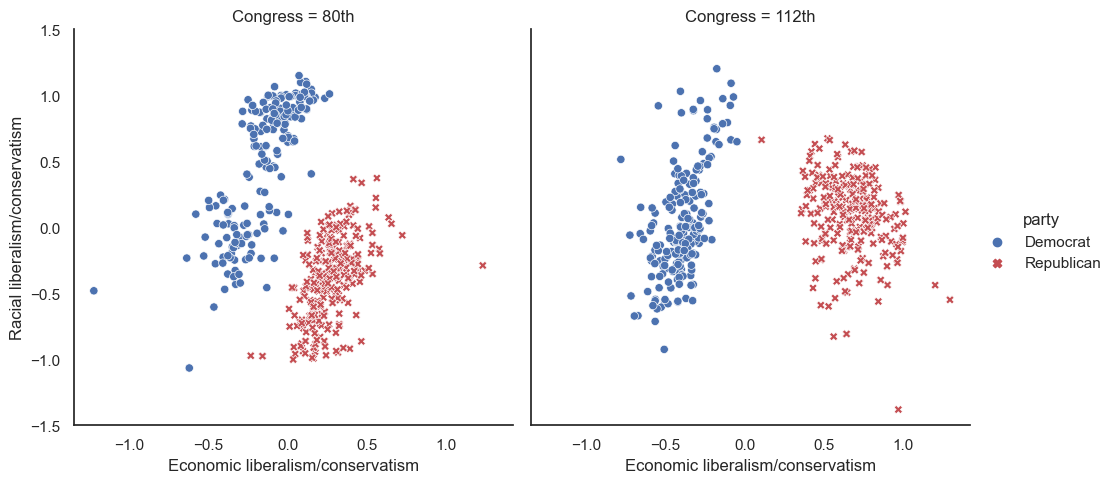

In [36]:
# store some plotting parameters for re-use
xlab='Economic liberalism/conservatism'
ylab='Racial liberalism/conservatism'
lim=(-1.5, 1.5)

sns.set_theme(style="white")

# scatterplot: facets for 80th and 112th congresses
sns.relplot(
    data=congress.loc[(congress['congress'].isin([80,112])) & 
                      (congress['party'] != 'Other')],
    x='dwnom1', y='dwnom2', hue='party', style='party', palette=['b', 'r'],
    col='Congress', col_wrap=2
).set(xlabel=xlab, ylabel=ylab, ylim=lim)

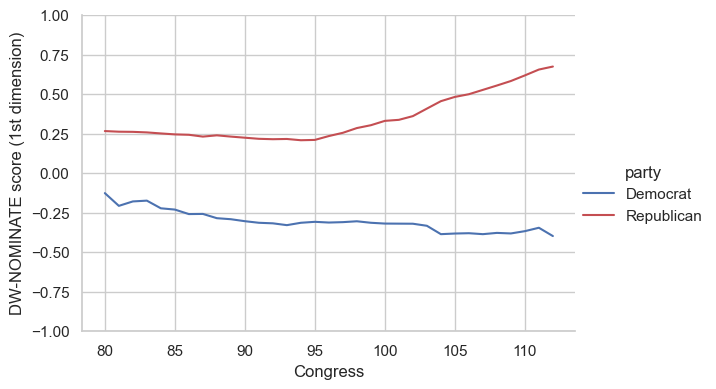

In [37]:
# Find the median for combinations of party and congress
dwn1_med = (congress.loc[congress.party != 'Other'].
            groupby(['party', 'congress'])['dwnom1'].median().reset_index())

sns.set_theme(style="whitegrid")

sns.relplot(
    data=dwn1_med, x='congress', y='dwnom1', hue='party', kind='line',
    palette=['b', 'r'], height=4, aspect=1.5
).set(ylim=(-1, 1), xlabel='Congress', 
      ylabel='DW-NOMINATE score (1st dimension)')

### Section 3.6.2: Correlation {-}

[Text(0.5, 1.0, 'Income Inequality'),
 Text(0, 0.5, 'Gini coefficient'),
 Text(0.5, 0, 'Year')]

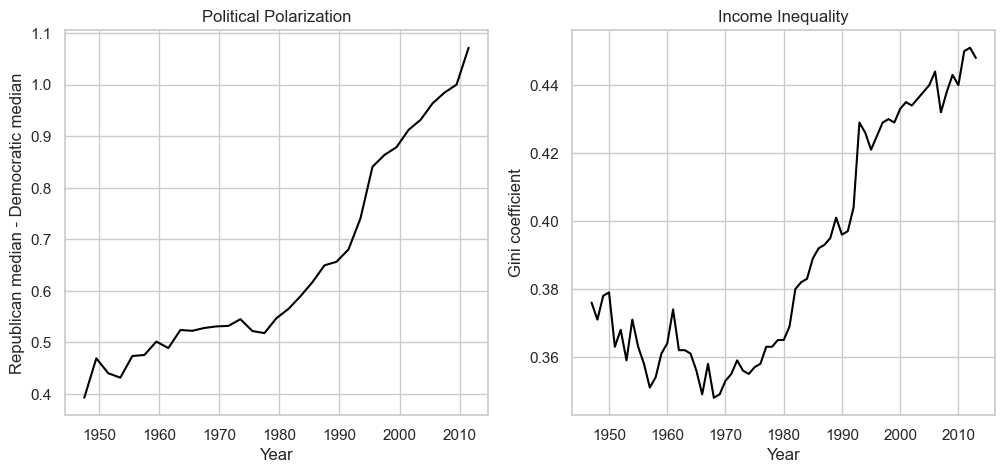

In [38]:
gini = pd.read_csv('USGini.csv')

'''
Calculate the difference between the Republican and Democratic medians.

pandas will try to align indexes in conducting vector arithmetic. Therefore, 
it is best to reset the index and drop the old one so that the indexes are the
same. An alternative is to use numpy arrays. 
'''
med_diff = (
    dwn1_med['dwnom1'][dwn1_med.party=='Republican'].reset_index(drop=True) - 
    dwn1_med['dwnom1'][dwn1_med.party=='Democrat'].reset_index(drop=True)
)

# Plot political polarization and income inequality side-by-side
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# time series plot for partisan differences 
# notice, we can feed x and y directly
sns.lineplot(
    x=np.arange(1947.5, 2012.5, step=2), y=med_diff, color='black', ax=axs[0]
).set(title='Political Polarization', xlabel='Year',
      ylabel='Republican median - Democratic median')

# time-series plot for Gini coefficient
sns.lineplot(
    data=gini, x='year', y='gini', color='black', ax=axs[1]
).set(title='Income Inequality', ylabel='Gini coefficient', xlabel='Year')

To correlate the partisan difference with the Gini coefficient, we need to select every other observation for the Gini starting with the second observation. 

In [39]:
(gini['gini'].iloc[np.arange(1, gini.shape[0], step=2)].
 reset_index(drop=True).corr(med_diff))

0.9418128160619333

### Section 3.6.3: Comparing Histograms {-}

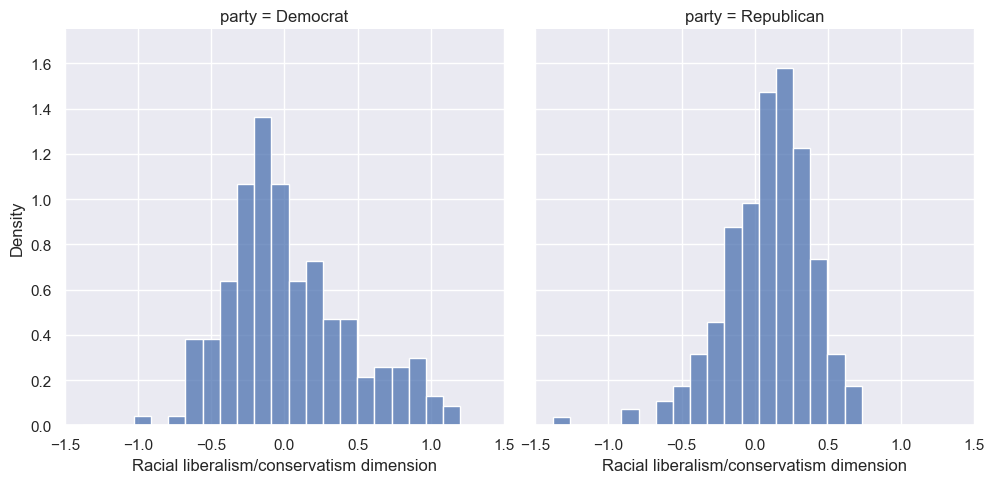

In [40]:
sns.set_theme(style="darkgrid")

# Facets: use common_norm=False to ensure density is calculated for each facet
sns.displot(
    data=congress.loc[(congress['congress'] == 112) & 
                      (congress['party'] != 'Other')],
    x='dwnom2', col='party', stat='density', common_norm=False
).set(xlim=(-1.5, 1.5), ylim=(0, 1.75), 
      xlabel='Racial liberalism/conservatism dimension')

A kernel density estimation (KDE) plot is useful if we want to overlay distributions. 

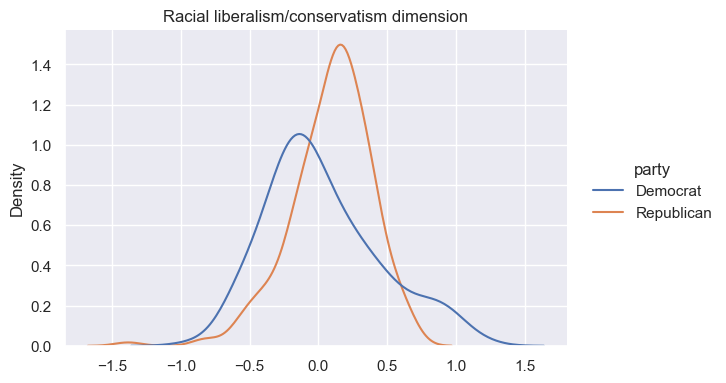

In [41]:
sns.displot(
    data=congress.loc[(congress['congress'] == 112) & 
                      (congress['party'] != 'Other')],
    x='dwnom2', hue='party', kind='kde', common_norm=False, 
    height=4, aspect=1.5
).set(title='Racial liberalism/conservatism dimension', xlabel='')

### Section 3.6.4: Quantile-Quantile Plot {-}

Seaborn does not have a built-in function for Q-Q plots. However, we can 
create a scatterplot of the quantiles of two variables. The quantiles we plot need to be the same length. Below, we calculate and plot percentiles.

In [42]:
dem112 = congress.loc[(congress['congress'] == 112) & 
                      (congress['party'] == 'Democrat')]

rep112 = congress.loc[(congress['congress'] == 112) & 
                      (congress['party'] == 'Republican')]

quantiles = np.linspace(0, 1, 101)

demq = dem112['dwnom2'].quantile(quantiles)
repq = rep112['dwnom2'].quantile(quantiles)

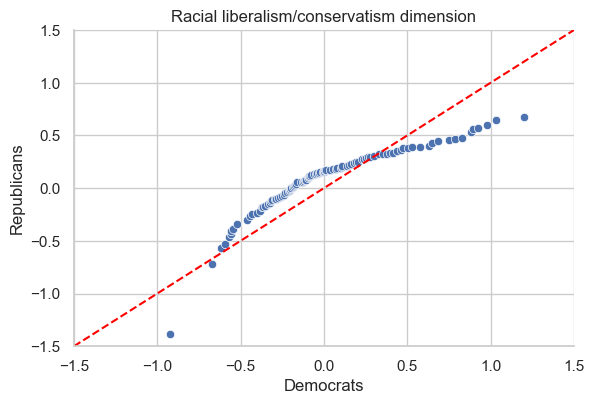

In [43]:
sns.set_theme(style="whitegrid")

sns.relplot(
    x = demq, y = repq, height=4, aspect=1.5
).set(xlabel='Democrats', ylabel='Republicans',
      title='Racial liberalism/conservatism dimension',
      ylim=(-1.5, 1.5), xlim=(-1.5, 1.5))

plt.gca().axline((0, 0), slope=1, color='red', linestyle='--')

## Section 3.7: Clustering {-}

Before implementing clustering with the k-Means algorithm, we discuss numpy arrays and objects in Python, both of which are important for many Python modeling libraries.

### Section 3.7.1: Numpy Arrays {-}

Thus far, we have used the [numpy](https://numpy.org/doc/stable/index.html) library for specific tasks, such as vectorized if-else statements using `np.where()` and log transformations using `np.log()`, but we have primarily relied on pandas for our analytical infrastructure. Having at least a high-level understanding of how numpy works is important for effective data analytics in Python. Indeed, pandas is built on top of numpy. While Python modeling libraries often work well with pandas, they occasionally work better with numpy, and many modeling outputs are numpy objects, as we will see in 3.7.3. 

The fundamental numpy data structure is the N-dimensional array, known as the `ndarray`. For those coming from an R background, a one-dimensional numpy array is similar to a vector in R. There are a number of ways to create a numpy vector, depending on the analytical context. 

In [44]:
# One-dimensional arrays as vectors

# create a one-dimensional numpy array

## from a list
x = np.array([10, 20, 30, 40, 50])

x

array([10, 20, 30, 40, 50])

In [45]:
## from a sequence
y = np.arange(10, 60, 10)

y

array([10, 20, 30, 40, 50])

In [46]:
## from random draws from a uniform distribution between 50 and 100
z = np.random.uniform(low=50, high=100, size=10)

z

array([98.7638964 , 86.34751158, 86.17164126, 65.8890982 , 75.87440146,
       74.99724337, 95.72619391, 83.34860259, 56.11908939, 93.98316394])

Indexing and slicing numpy arrays is similar to indexing and slicing Python lists. 

In [47]:
# select the first observation from z
## recall, Python uses zero-based indexing
z[0]

98.76389640163184

In [48]:
# select the first five observations from z
## recall, Python uses "up to but not including" slicing semantics
z[0:5]

array([98.7638964 , 86.34751158, 86.17164126, 65.8890982 , 75.87440146])

In [49]:
# select the fifth observation onward
z[4:]

array([75.87440146, 74.99724337, 95.72619391, 83.34860259, 56.11908939,
       93.98316394])

In base Python, we need to use for loops to perform operations on each element of a list. Numpy, by contrast, enables vectorized computations. 

In [50]:
# conduct vectorized arithmetic: multiply each element by .25
z * .25

array([24.6909741 , 21.58687789, 21.54291032, 16.47227455, 18.96860037,
       18.74931084, 23.93154848, 20.83715065, 14.02977235, 23.49579099])

In [51]:
# conduct conditional vectorized arithmetic
## if an element is above 75, multiply by .25; otherwise, multiply by .75
np.where(z > 75, z * .25, z * .75)

array([24.6909741 , 21.58687789, 21.54291032, 49.41682365, 18.96860037,
       56.24793253, 23.93154848, 20.83715065, 42.08931704, 23.49579099])

In [52]:
# calculate the sum of the elements
z.sum()

817.2208421076365

In [53]:
# calculate the mean of the elements
z.mean()

81.72208421076365

Two-dimensional numpy arrays can be thought of as matrices.

In [54]:
# create a two-dimensional numpy array from a range
mat = np.arange(0, 10).reshape(5, 2)

mat

array([[0, 1],
       [2, 3],
       [4, 5],
       [6, 7],
       [8, 9]])

In [55]:
# select the first row
mat[0]

array([0, 1])

In [56]:
# select the second column
mat[:,1]

array([1, 3, 5, 7, 9])

In [57]:
# select the first two rows and the second column
mat[0:2, 1]

array([1, 3])

In [58]:
# calculate the sum of the columns
mat.sum(axis=0)

array([20, 25])

In [59]:
# calculate the mean of the rows
mat.mean(axis=1)

array([0.5, 2.5, 4.5, 6.5, 8.5])

In [60]:
# calculate the standard deviation of the columns
mat.std(axis=0)

array([2.82842712, 2.82842712])

A matrix generally must have the same data type for all elements. A data frame can have different data types for each column.

In [61]:
df = pd.DataFrame({'x': ['a', 'b', 'c'], 'y': [1, 2, 3]})

df.dtypes # contains a string and an integer

x    object
y     int64
dtype: object

In [62]:
np.array(df).dtype # produces a dtype 'O' for object; in other words, a string

dtype('O')

### Section 3.7.2: Objects in Python {-}

In Python, it is said that "everything is an object." Python makes heavy use of object oriented programming (OOP), a programming paradigm that involves grouping code and data together into objects. In OOP, an object is created from a template called a "class." The data associated with objects are generally called attributes, and the functions are called methods. Libraries like pandas, numpy, and seaborn are designed so that we do not have to worry too much about OOP particulars. Still, it is important to recognize that we are working with objects of specific classes that have attributes and methods. 

In [63]:
# check the object class 
type(congress)

pandas.core.frame.DataFrame

In [64]:
# review an object's methods and attributes; print the first 15
dir(congress)[0:15]

['Congress',
 'T',
 '_AXIS_LEN',
 '_AXIS_ORDERS',
 '_AXIS_TO_AXIS_NUMBER',
 '_HANDLED_TYPES',
 '__abs__',
 '__add__',
 '__and__',
 '__annotations__',
 '__array__',
 '__array_priority__',
 '__array_ufunc__',
 '__bool__',
 '__class__']

In [65]:
# use a list comprehension to view the non-private attributes and methods
[item for item in dir(congress) if not item.startswith('_')][0:15]

['Congress',
 'T',
 'abs',
 'add',
 'add_prefix',
 'add_suffix',
 'agg',
 'aggregate',
 'align',
 'all',
 'any',
 'apply',
 'applymap',
 'asfreq',
 'asof']

In [66]:
# use the data frame's value_counts "method"
congress['party'].value_counts()

party
Democrat      8132
Republican    6401
Other           19
Name: count, dtype: int64

In [67]:
# review the data frame's shape "attribute"
congress.shape

(14552, 8)

As we will see in 3.7.3, some important modeling libraries in Python, such as scikit-learn, rely on a more conventional OOP workflow. In such a workflow, one generally follows a few key steps: 

- Select a class. 
- Instantiate an object of the class and set desired parameters. 
- Use the object's methods to perform operations on data. 
- Extract results from the object.

### Section 3.7.3: The k-Means Algorithm {-}

In [68]:
from sklearn.cluster import KMeans

dwnom80 = congress.loc[congress['congress']==80, ['dwnom1', 'dwnom2']].copy()

dwnom112 = congress.loc[congress['congress']==112, ['dwnom1', 'dwnom2']].copy()

# kmeans with two clusters

## instantiate the model with parameters
k80two = KMeans(n_clusters=2, n_init=5)
k112two = KMeans(n_clusters=2, n_init=5)

If you are working on Windows, you may get a warning about about memory 
leakage associated with using KMeans on Windows. The warning will likely
recommend setting the environmental variable OPM_NUM_THREADS to a certain value. To do so, follow these steps: 

- (1) Click on the Windows Search button
- (2) Type "Edit the system environment variables"
- (3) Select "Environment Variables"
- (4) Click "New" under "User variables for your_username"
- (5) Enter "OMP_NUM_THREADS" for the variable name and '1' or the number recommended in the warning for the variable value
- (6) Click "OK" and close the windows

In [69]:
## fit the model to the data
k80two.fit(dwnom80)
k112two.fit(dwnom112)

## predict the clusters
k80two_labels = k80two.predict(dwnom80)
k112two_labels = k112two.predict(dwnom112)

type(k80two_labels) # numpy.ndarray

numpy.ndarray

In [70]:
# Use a list comprehension to view the non-private methods and attributes
[item for item in dir(k80two) if not item.startswith('_')]

['algorithm',
 'cluster_centers_',
 'copy_x',
 'feature_names_in_',
 'fit',
 'fit_predict',
 'fit_transform',
 'get_feature_names_out',
 'get_params',
 'inertia_',
 'init',
 'labels_',
 'max_iter',
 'n_clusters',
 'n_features_in_',
 'n_init',
 'n_iter_',
 'predict',
 'random_state',
 'score',
 'set_output',
 'set_params',
 'tol',
 'transform',
 'verbose']

In [71]:
# final centroids
k80two.cluster_centers_

array([[-0.05605797,  0.76863044],
       [ 0.15212662, -0.34353896]])

In [72]:
k112two.cluster_centers_

array([[ 0.67767355,  0.09061157],
       [-0.39126866,  0.03260696]])

In [73]:
type(k112two.cluster_centers_) # numpy.ndarray

numpy.ndarray

In [74]:
# number of observations for each cluster by party
pd.crosstab(congress['party'][congress.congress == 80], 
            k80two_labels, colnames=['cluster'])

cluster,0,1
party,,
Democrat,135,59
Other,0,2
Republican,3,247


In [75]:
pd.crosstab(congress['party'][congress.congress == 112],
            k112two_labels, colnames=['cluster'])

cluster,0,1
party,,
Democrat,0,200
Republican,242,1


In [76]:
# k means with four clusters
k80four = KMeans(n_clusters=4, n_init=5)
k112four = KMeans(n_clusters=4, n_init=5)

k80four.fit(dwnom80)
k112four.fit(dwnom112)

k80four_labels = k80four.predict(dwnom80)
k112four_labels = k112four.predict(dwnom112)

<Axes: title={'center': '112th Congress'}, xlabel='Economic liberalism/conservatism'>

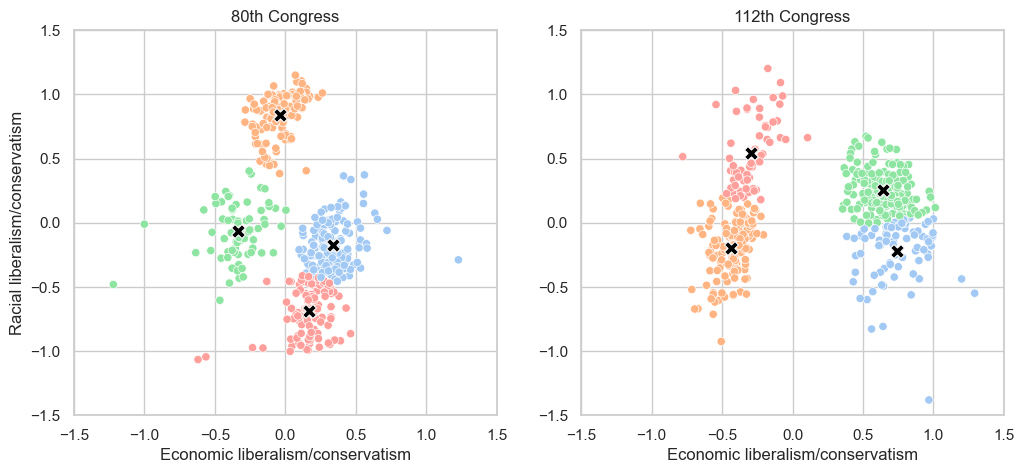

In [77]:
# plot the clusters
fig, axs = plt.subplots(1,2, figsize=(12, 5))

sns.scatterplot(
    data=dwnom80, x='dwnom1', y='dwnom2', hue=k80four_labels, legend=False,
    palette='pastel', ax=axs[0],
    ).set(title='80th Congress', xlabel=xlab, ylabel=ylab, xlim=lim, ylim=lim)

sns.scatterplot(
    x=k80four.cluster_centers_[:,0], y=k80four.cluster_centers_[:,1], 
    legend=False, color='black', s=100, marker='X', ax=axs[0],
    )

sns.scatterplot(
    data=dwnom112, x='dwnom1', y='dwnom2', hue=k112four_labels, legend=False,
    palette='pastel', ax=axs[1],
    ).set(title='112th Congress', xlabel=xlab, ylabel='', xlim=lim, ylim=lim)

sns.scatterplot(
    x=k112four.cluster_centers_[:,0], y=k112four.cluster_centers_[:,1], 
    legend=False, color='black', s=100, marker='X', ax=axs[1],
    )